In [1]:
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import os
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import lightning as pl
import torchmetrics
import comet_ml
import os
from lightning.pytorch import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from comet_ml import Experiment
import pandas as pd
import numpy as np
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
from mediapipe_handcrop import MediapipeHandCrop
from tqdm import tqdm

## CUDA SETUP

In [2]:
def setup_device():
    if torch.cuda.is_available():
        device = torch.device('cuda')
        torch.set_default_dtype(torch.float32)
    else:
        device = torch.device('cpu')
        torch.set_default_dtype(torch.float32)
    return device

device = setup_device()
print(f"Using {device} device")

# Set random seed for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

Using cuda device


## CREATE TRAIN AND TEST CSV FILES

In [3]:
def average_brightness(image_path):
    # Wczytanie obrazu
    image = cv2.imread(image_path)
    
    # Sprawdzenie, czy obraz został poprawnie wczytany
    if image is None:
        print("Nie udało się wczytać obrazu.")
        return None

    # Konwersja obrazu do przestrzeni barw HSV
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Ekstrakcja kanału jasności (V)
    brightness_channel = hsv_image[:, :, 2]

    # Obliczenie średniej jasności
    average_brightness = np.mean(brightness_channel)

    # print(f"{average_brightness = }")

    return average_brightness > 135.0


In [4]:
train_pth = r"C:\Users\Hyperbook\Desktop\STUDIA\DLF3\DLF-sign_letters_classification\new_dataset\train"
test_pth = r"C:\Users\Hyperbook\Desktop\STUDIA\DLF3\DLF-sign_letters_classification\new_dataset\test"

mediapipe_validator = MediapipeHandCrop(include_characteristic_vectors=True)

def validate_dataset_with_mediapipe(dataset_path, csv_file_path, new_dir):
    data = []
    classes_to_ignore = ["del", "nothing", "space"]
    index = 0
    for class_name in os.listdir(dataset_path):
        items = []
        if class_name not in classes_to_ignore:
            # Create a dir for new validated class images
            new_class_path = os.path.join(new_dir, class_name)
            os.makedirs(new_class_path, exist_ok=True)

            class_index = ord(class_name) - 65
            count = 0
            for image_name in tqdm(os.listdir(os.path.join(dataset_path,class_name))):
                image_path = os.path.join(dataset_path, class_name, image_name)
                
                # Validate image with mediapipe and brigthness
                try:
                    if average_brightness(image_path):
                        result = mediapipe_validator(image_path)
                        # if result is None:
                        #     continue
                        cropped_image, characteristic_vectors = result

                        # Moving cropped image to new directory
                        new_image_path = os.path.join(new_class_path, image_name)
                        cv2.imwrite(new_image_path, cropped_image)

                        data.append({"image_path": new_image_path, "characteristic_vectors": characteristic_vectors, "class_name": class_name, "class_index": class_index, "index":index})
                        index+=1
                        count+=1

                except Exception as e:
                    pass
                    # print(f"Mediapipe didn't detect any hands {image_path}: {e}")
                
            print(f"Saved {count} images from class {class_name}")


    df = pd.DataFrame(data)
    df.to_csv(csv_file_path, index=False)


In [5]:
# Create csv and dir
validate_dataset_with_mediapipe(train_pth, 
                                csv_file_path = r"new_dataset/validated_train_csv.csv",
                                new_dir = r"new_dataset/validated_train")

  0%|          | 0/8458 [00:00<?, ?it/s]

100%|██████████| 8458/8458 [01:45<00:00, 80.11it/s]  


Saved 3213 images from class A


100%|██████████| 8309/8309 [02:06<00:00, 65.43it/s]  


Saved 4149 images from class B


100%|██████████| 8146/8146 [02:25<00:00, 56.11it/s] 


Saved 3971 images from class C


100%|██████████| 7629/7629 [02:27<00:00, 51.81it/s] 


Saved 4906 images from class D


100%|██████████| 7744/7744 [02:01<00:00, 63.62it/s]  


Saved 4049 images from class E


100%|██████████| 8031/8031 [02:07<00:00, 62.81it/s]  


Saved 4631 images from class F


100%|██████████| 7844/7844 [01:40<00:00, 77.71it/s]  


Saved 3273 images from class G


100%|██████████| 7906/7906 [01:52<00:00, 70.22it/s] 


Saved 3483 images from class H


100%|██████████| 7953/7953 [02:18<00:00, 57.24it/s] 


Saved 4352 images from class I


100%|██████████| 7503/7503 [02:00<00:00, 62.20it/s] 


Saved 3929 images from class J


100%|██████████| 7876/7876 [02:25<00:00, 54.17it/s] 


Saved 4957 images from class K


100%|██████████| 7939/7939 [02:35<00:00, 51.07it/s] 


Saved 5446 images from class L


100%|██████████| 7900/7900 [01:55<00:00, 68.35it/s] 


Saved 2804 images from class M


100%|██████████| 7932/7932 [01:46<00:00, 74.28it/s] 


Saved 2480 images from class N


100%|██████████| 8140/8140 [02:33<00:00, 53.14it/s] 


Saved 4656 images from class O


100%|██████████| 7601/7601 [02:05<00:00, 60.47it/s] 


Saved 3751 images from class P


100%|██████████| 7954/7954 [02:12<00:00, 59.87it/s] 


Saved 4153 images from class Q


100%|██████████| 8021/8021 [02:31<00:00, 52.81it/s] 


Saved 4873 images from class R


100%|██████████| 8109/8109 [02:25<00:00, 55.90it/s] 


Saved 4708 images from class S


100%|██████████| 8054/8054 [02:08<00:00, 62.72it/s] 


Saved 4037 images from class T


100%|██████████| 8023/8023 [02:23<00:00, 55.92it/s] 


Saved 4763 images from class U


100%|██████████| 7597/7597 [01:59<00:00, 63.46it/s] 


Saved 4095 images from class V


100%|██████████| 7787/7787 [02:21<00:00, 55.08it/s] 


Saved 4728 images from class W


100%|██████████| 8093/8093 [02:10<00:00, 61.98it/s] 


Saved 3969 images from class X


100%|██████████| 8178/8178 [02:15<00:00, 60.25it/s] 


Saved 4506 images from class Y


100%|██████████| 7410/7410 [02:03<00:00, 59.94it/s] 


Saved 4243 images from class Z


In [6]:
validate_dataset_with_mediapipe(test_pth, 
                                csv_file_path = r"new_dataset/validated_test_csv.csv",
                                new_dir = r"new_dataset/validated_test")

100%|██████████| 30/30 [00:00<00:00, 49.80it/s]


Saved 24 images from class A


100%|██████████| 30/30 [00:00<00:00, 43.12it/s]


Saved 23 images from class B


100%|██████████| 30/30 [00:00<00:00, 42.18it/s]


Saved 22 images from class C


100%|██████████| 30/30 [00:00<00:00, 33.58it/s]


Saved 25 images from class D


100%|██████████| 30/30 [00:00<00:00, 33.79it/s]


Saved 25 images from class E


100%|██████████| 30/30 [00:00<00:00, 38.20it/s]


Saved 26 images from class F


100%|██████████| 30/30 [00:00<00:00, 34.58it/s]


Saved 30 images from class G


100%|██████████| 30/30 [00:00<00:00, 41.52it/s]


Saved 24 images from class H


100%|██████████| 30/30 [00:00<00:00, 45.02it/s]


Saved 16 images from class I


100%|██████████| 30/30 [00:00<00:00, 34.85it/s]


Saved 30 images from class J


100%|██████████| 30/30 [00:00<00:00, 41.70it/s]


Saved 22 images from class K


100%|██████████| 30/30 [00:00<00:00, 37.92it/s]


Saved 26 images from class L


100%|██████████| 30/30 [00:00<00:00, 37.17it/s]


Saved 27 images from class M


100%|██████████| 30/30 [00:00<00:00, 37.84it/s]


Saved 26 images from class N


100%|██████████| 30/30 [00:00<00:00, 35.78it/s]


Saved 22 images from class O


100%|██████████| 30/30 [00:00<00:00, 36.60it/s]


Saved 28 images from class P


100%|██████████| 30/30 [00:00<00:00, 35.06it/s]


Saved 28 images from class Q


100%|██████████| 30/30 [00:00<00:00, 34.93it/s]


Saved 30 images from class R


100%|██████████| 30/30 [00:00<00:00, 40.94it/s]


Saved 23 images from class S


100%|██████████| 30/30 [00:00<00:00, 33.95it/s]


Saved 30 images from class T


100%|██████████| 30/30 [00:00<00:00, 40.81it/s]


Saved 25 images from class U


100%|██████████| 30/30 [00:00<00:00, 35.81it/s]


Saved 28 images from class V


100%|██████████| 30/30 [00:00<00:00, 35.51it/s]


Saved 29 images from class W


100%|██████████| 30/30 [00:00<00:00, 41.23it/s]


Saved 25 images from class X


100%|██████████| 30/30 [00:00<00:00, 39.91it/s]


Saved 27 images from class Y


100%|██████████| 30/30 [00:00<00:00, 34.96it/s]


Saved 30 images from class Z


## DATASET

In [3]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    # transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Values calculated from the ImageNet dataset
])

class Dataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.transform = transform
        self.df = pd.read_csv(self.csv_file)
        self.classes = sorted(np.unique(self.df["class_index"]))
        self.class_names = sorted(np.unique(self.df["class_name"]))
        
    def __len__(self):
        dataset_len = sum([len(os.listdir(self.root_dir + class_)) for class_ in self.class_names])
        return dataset_len
    
    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("Index out of bounds")
        
        label = self.df.loc[index, "class_index"]
        image_path = self.df.loc[index, "image_path"]

        # Loading image with cv2
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        # height, width = image.shape[:2]
        
        # Converting to RGB
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        # Transform
        if self.transform:
            image = self.transform(Image.fromarray(image))

            # # Przeskalowanie wektorów
            # scale_x = 64 / width
            # scale_y = 64 / height
            # characteristic_vectors = self.df.loc[index, "characteristic_vectors"]
            # scaled_vectors = characteristic_vectors * np.array([scale_x, scale_y, 1])
        
        return image, label#, scaled_vectors
        

In [4]:
# Train dataset and dataloader initialization
train_dataset = Dataset(root_dir="./new_dataset/validated_train/",
                        csv_file= "./new_dataset/validated_train_csv.csv",
                        transform=transform)

Dataset len:
108125

Dataset classes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

Random images from dataset:


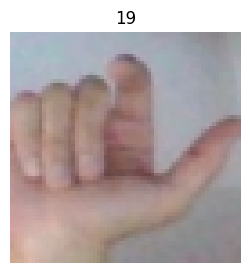

In [36]:
# Sanity check
print("Dataset len:")
print(len(train_dataset))

print("\nDataset classes:")
print(train_dataset.classes)

print("\nRandom images from dataset:")
img, label = train_dataset[random.randint(0, len(train_dataset)-1)]
image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

# Denormalizing (there was normalization in transform)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * std + mean
image = image.clip(0, 1)

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.axis("off")
plt.title(label)
plt.show()


In [37]:
# Train dataset and dataloader initialization
test_dataset = Dataset(root_dir="./new_dataset/validated_test/",
                        csv_file= "./new_dataset/validated_test_csv.csv",
                        transform=transform)

Dataset len:
674

Dataset classes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

Random image from dataset:


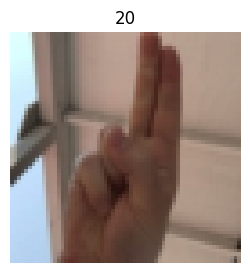

In [76]:
# Sanity check
print("Dataset len:")
print(len(test_dataset))

print("\nDataset classes:")
print(test_dataset.classes)

print("\nRandom image from dataset:")
img, label = test_dataset[random.randint(0, len(test_dataset)-1)]
image = img.permute(1, 2, 0).numpy()  # [C, H, W] -> [H, W, C]

# Denormalizing (there was normalization in transform)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
image = image * std + mean
image = image.clip(0, 1)

plt.figure(figsize=(3,3))
plt.imshow(image)
plt.axis("off")
plt.title(label)
plt.show()

## SPLITING DATA INTO TRAINING AND VALIDATION DATASETS

In [54]:
train_len = round(0.7 * len(train_dataset))
val_len = len(train_dataset) - train_len
train_len, val_len, train_len + val_len == len(train_dataset)

(75688, 32437, True)

In [55]:
train_dataset_, val_dataset = random_split(train_dataset, [train_len, val_len])

In [56]:
# Sanity check once more

print(f"Number of training samples: {len(train_dataset_)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of train classes: {len(train_dataset_.dataset.classes)}")
print(f"Number of val classes: {len(val_dataset.dataset.classes)}")
print(f"Number of test samples: {len(test_dataset)}") 


Number of training samples: 75688
Number of validation samples: 32437
Number of train classes: 26
Number of val classes: 26
Number of test samples: 674


In [57]:
print(f"Train dataset classes: {train_dataset.classes}")
print(f"Validation dataset classes: {train_dataset.classes}")

Train dataset classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Validation dataset classes: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]


## DATALOADERS

In [58]:
import os
num_workers = os.cpu_count()
print(f"Suggested num_workers: {num_workers}")

Suggested num_workers: 24


In [103]:
train_dataloader = DataLoader(train_dataset_, 
                              batch_size=32, 
                              shuffle=True, 
                              num_workers=0)

val_dataloader = DataLoader(val_dataset,
                            batch_size=32,
                            shuffle=False,
                            num_workers=0)

test_dataloader = DataLoader(test_dataset, 
                             batch_size=32, 
                             shuffle=False, 
                             num_workers=0)


In [60]:
# Sanity check
def loader_sanity_check(loader):
    for batch_idx, (data, labels) in enumerate(loader):
        print(f"Batch nr: {batch_idx}")
        print(f"Batch size: {data.shape[0]}")
        print(f"Data shape: {data.shape}")
        print(f"Image shape: {data[0].shape}")
        print(f"Classes: {labels}")
        print(f"Num classes: {len(labels)}")
        break

In [61]:
loader_sanity_check(train_dataloader)

Batch nr: 0
Batch size: 32
Data shape: torch.Size([32, 3, 64, 64])
Image shape: torch.Size([3, 64, 64])
Classes: tensor([18, 11,  9,  9, 11, 20,  8, 20, 15,  2,  9,  1, 15, 23, 12,  1,  5, 15,
        10, 24, 14,  2, 24,  5, 11, 11, 25,  5, 15, 13,  7, 12])
Num classes: 32


In [62]:
loader_sanity_check(val_dataloader)

Batch nr: 0
Batch size: 32
Data shape: torch.Size([32, 3, 64, 64])
Image shape: torch.Size([3, 64, 64])
Classes: tensor([15,  9, 21,  6, 18, 15, 20,  8, 22,  0,  1, 10, 10,  7, 18,  1, 17,  7,
        13, 17, 15, 22,  7,  0,  8,  0, 16, 21, 11, 19,  5, 19])
Num classes: 32


In [63]:
loader_sanity_check(test_dataloader)

Batch nr: 0
Batch size: 32
Data shape: torch.Size([32, 3, 64, 64])
Image shape: torch.Size([3, 64, 64])
Classes: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 1, 1, 1, 1, 1, 1])
Num classes: 32


## COMET_ML SETUP

In [73]:
from comet_ml import Experiment

# Initialize Comet.ml experiment
experiment = Experiment(
    api_key=os.getenv("COMET_API_KEY"),
    project_name="DLF-sign_letters_classification",
)

experiment.set_name("New validated dataset, Mobilenet test1")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : New validated dataset, Mobilenet test1
COMET INFO:     url                   : https://www.comet.com/ziemmi13/dlf-sign-letters-classification/fc6a9c0a60e7458faf682ebaef43da1d
COMET INFO:   Metrics:
COMET INFO:     train_loss : 9.718859672546387
COMET INFO:   Others:
COMET INFO:     Name : New validated dataset, Mobilenet test1
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     learning_rate : 0.0001
COMET INFO:     num_epochs    : 3
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filen

## Define helper functions to logs gradients and weights

In [74]:
def to_numpy(x):
    return x.detach().numpy()


def update_gradient_map(model, gradmap):
    for name, layer in zip(model._modules, model.children()):
        if "activ" in name:
            continue

        if not hasattr(layer, "weight"):
            continue

        wname = "%s/%s.%s" % ("gradient", name, "weight")
        bname = "%s/%s.%s" % ("gradient", name, "bias")

        gradmap.setdefault(wname, 0)
        gradmap.setdefault(bname, 0)

        gradmap[wname] += layer.weight.grad
        gradmap[bname] += layer.bias.grad

    return gradmap


def log_gradients(gradmap, step):
    for k, v in gradmap.items():
        experiment.log_histogram_3d(to_numpy(v), name=k, step=step)


def log_weights(model, step):
    for name, layer in zip(model._modules, model.children()):
        if "activ" in name:
            continue

        if not hasattr(layer, "weight"):
            continue

        wname = "%s.%s" % (name, "weight")
        bname = "%s.%s" % (name, "bias")

        experiment.log_histogram_3d(to_numpy(layer.weight), name=wname, step=step)
        experiment.log_histogram_3d(to_numpy(layer.bias), name=bname, step=step)

## PRETRAINED MODEL (MOBILE_NET)

In [75]:
# Using pretrained model (transfer learning)
weights = MobileNet_V2_Weights.DEFAULT
model = mobilenet_v2(weights=weights).to(device)

# Freeze the convolutional layers
for param in model.features.parameters():
    param.requires_grad = False

# Ensure classifier requires grad
for param in model.classifier.parameters():
    param.requires_grad = True

# Change classifier (fc) to satisfy aplication
num_classes = len(train_dataset.classes)
num_inputs = model.last_channel

model.fc = nn.Sequential(
    nn.Linear(num_inputs, 256),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(256, num_classes)).to(device)

In [76]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## MODEL PARAMETERS

In [77]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
frozen_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print(f"All parameters: {total_params}")
print(f"Frozen parameters: {frozen_params}")
print(f"Trainable parameters: {trainable_params}")


All parameters: 3839490
Frozen parameters: 2223872
Trainable parameters: 1615618


In [78]:
learning_rate = 0.0001
batch_size = 32
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4) # https://paperswithcode.com/method/weight-decay
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3) # https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
num_epochs = 3

hyper_params = {"batch_size": batch_size, "num_epochs": num_epochs, "learning_rate": learning_rate}
experiment.log_parameters(hyper_params)

In [79]:
def train_model(device, model, train_loader, val_loader, criterion, optimizer, num_epochs, resume_path=None):
    train_losses = []
    val_losses = []

    # Load checkpoint if provided
    start_epoch = 0
    if resume_path:
        checkpoint = torch.load(resume_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        print(f"Resuming training from epoch {start_epoch}")

    model.to(device)

    print(f"Starting Training")
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Accumulate batch loss (not divided by dataset size)
            running_loss += loss.item()

            _, predicted = outputs.max(1)
            train_total += labels.size(0)
            train_correct += predicted.eq(labels).sum().item()

           # Log every 50 batches
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item():.4f}')
                experiment.log_metric("train_loss", loss.item(), step=batch_idx + len(train_loader) * batch_idx)

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)  # Average loss per batch
        train_accuracy = 100. * train_correct / train_total
        train_losses.append(epoch_loss)

        # Log epoch metrics
        experiment.log_metric("epoch_train_loss", epoch_loss, step=epoch)
        experiment.log_metric("epoch_train_accuracy", train_accuracy, step=epoch)

        val_losses = []
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        print("Validating...")
        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()

                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_loss / len(val_loader)
        val_accuracy = 100. * val_correct / val_total
        val_losses.append(val_epoch_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        print('-' * 60)

        # Log validation metrics
        experiment.log_metric("val_loss", val_epoch_loss, step=epoch)
        experiment.log_metric("val_accuracy", val_accuracy, step=epoch)

        # Save model checkpoint
        checkpoint_path = f"./models/save_epoch_{epoch}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }, checkpoint_path)

        model_path = f"./models/New vaidated dataset MobileNet model, epoch {epoch}"
        weights_path = f"./models/New vaidated dataset MobileNet weights, epoch {epoch}"

        torch.save(model, model_path)
        torch.save(model.state_dict(), weights_path)

        print(f"Model checkpoint saved at: {checkpoint_path}")

    return train_losses, val_losses

In [105]:
# Test loop
def test_model(device, model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    # Log test metrics
    experiment.log_metric("test_loss", test_loss)
    experiment.log_metric("test_accuracy", test_accuracy)

    return test_loss, test_accuracy

## TRAINING

In [81]:
train_losses, val_losses = train_model(device, model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs)

Starting Training
Epoch: 1, Batch: 0, Loss: 9.2058
Epoch: 1, Batch: 100, Loss: 8.9996
Epoch: 1, Batch: 200, Loss: 7.3834
Epoch: 1, Batch: 300, Loss: 6.5608
Epoch: 1, Batch: 400, Loss: 6.0558
Epoch: 1, Batch: 500, Loss: 5.4208
Epoch: 1, Batch: 600, Loss: 4.8655
Epoch: 1, Batch: 700, Loss: 4.5407
Epoch: 1, Batch: 800, Loss: 4.3952
Epoch: 1, Batch: 900, Loss: 3.8147
Epoch: 1, Batch: 1000, Loss: 3.6217
Epoch: 1, Batch: 1100, Loss: 3.3520
Epoch: 1, Batch: 1200, Loss: 3.4900
Epoch: 1, Batch: 1300, Loss: 2.9089
Epoch: 1, Batch: 1400, Loss: 2.7392
Epoch: 1, Batch: 1500, Loss: 2.7593
Epoch: 1, Batch: 1600, Loss: 2.1705
Epoch: 1, Batch: 1700, Loss: 2.6217
Epoch: 1, Batch: 1800, Loss: 2.5039
Epoch: 1, Batch: 1900, Loss: 2.1294
Epoch: 1, Batch: 2000, Loss: 2.2521
Epoch: 1, Batch: 2100, Loss: 2.2361
Epoch: 1, Batch: 2200, Loss: 2.3967
Epoch: 1, Batch: 2300, Loss: 1.8356
Validating...
Epoch [1/3]
Training Loss: 3.9967, Training Accuracy: 20.56%
Validation Loss: 1.9715, Validation Accuracy: 51.94%
--

COMET ERROR: Due to connectivity issues, there's an error in processing the heartbeat. The experiment's status updates might be inaccurate until the connection issues are resolved.


Epoch: 3, Batch: 1000, Loss: 1.4043
Epoch: 3, Batch: 1100, Loss: 1.0910
Epoch: 3, Batch: 1200, Loss: 1.2253
Epoch: 3, Batch: 1300, Loss: 1.4265
Epoch: 3, Batch: 1400, Loss: 1.2155
Epoch: 3, Batch: 1500, Loss: 0.8954
Epoch: 3, Batch: 1600, Loss: 1.0271
Epoch: 3, Batch: 1700, Loss: 1.2099
Epoch: 3, Batch: 1800, Loss: 0.8983
Epoch: 3, Batch: 1900, Loss: 1.0882
Epoch: 3, Batch: 2000, Loss: 1.0083
Epoch: 3, Batch: 2100, Loss: 1.2282
Epoch: 3, Batch: 2200, Loss: 0.8663
Epoch: 3, Batch: 2300, Loss: 1.0330
Validating...
Epoch [3/3]
Training Loss: 1.2333, Training Accuracy: 69.58%
Validation Loss: 0.9495, Validation Accuracy: 79.18%
------------------------------------------------------------
Model checkpoint saved at: ./models/save_epoch_2.pt


In [82]:
# Saving model and weights
torch.save(model, "./models/New vaidated dataset MobileNet test1")
torch.save(model.state_dict(), "./models/New validated dataset MobileNet test1")

## Log the Model to Comet

In [83]:
from comet_ml.integration.pytorch import log_model

log_model(experiment, model, "New validated dataset MobileNet test1 - sign letters classification model")

## End Experiment

In [84]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : New validated dataset, Mobilenet test1
COMET INFO:     url                   : https://www.comet.com/ziemmi13/dlf-sign-letters-classification/a1e98f8c21344b4c8541207dc7073dfa
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch_train_accuracy [3] : (20.563365394778565, 69.5843462636085)


COMET INFO:     epoch_train_loss [3]     : (1.2333032162332576, 3.9967047474390354)
COMET INFO:     train_loss [72]          : (0.8663419485092163, 9.205835342407227)
COMET INFO:     val_accuracy [3]         : (51.94376791935136, 79.17501618522058)
COMET INFO:     val_loss [3]             : (0.9495286483912778, 1.9714663522483329)
COMET INFO:   Others:
COMET INFO:     Name : New validated dataset, Mobilenet test1
COMET INFO:   Parameters:
COMET INFO:     batch_size    : 32
COMET INFO:     learning_rate : 0.0001
COMET INFO:     num_epochs    : 3
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (4.58 MB)
COMET INFO:     installed packages       : 1
COMET INFO:     model-element            : 2 (14.88 MB)
COMET INFO:     notebook                 : 1
COMET INFO:     source_code              : 1
COMET INFO: 
COMET WARNING: To get all data l

## TESTING

In [100]:
transform = transforms.Compose([
    transforms.Resize((64,64)),
    # transforms.CenterCrop((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Values calculated from the ImageNet dataset
])


class Dataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.transform = transform
        self.df = pd.read_csv(self.csv_file)
        self.classes = sorted(np.unique(self.df["class_index"]))
        self.class_names = sorted(np.unique(self.df["class_name"]))
        
    def __len__(self):
        dataset_len = sum([len(os.listdir(self.root_dir + class_)) for class_ in self.class_names])
        return 670
    
    def __getitem__(self, index):
        if index >= len(self):
            raise IndexError("Index out of bounds")

        try:
            # Use iloc for position-based indexing
            label = self.df.iloc[index]["class_index"]
            image_path = self.df.iloc[index]["image_path"]

            # Check if file exists
            if not os.path.exists(image_path):
                raise FileNotFoundError(f"Image not found: {image_path}")

            # Load image
            image = cv2.imread(image_path, cv2.IMREAD_COLOR)
            if image is None:
                raise ValueError(f"Failed to read image at: {image_path}")
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Apply transform
            if self.transform:
                image = self.transform(Image.fromarray(image))

            return image, label

        except Exception as e:
            print(f"Error loading data at index {index}: {e}")
            raise

        
        
        

In [106]:
test_loss, test_accuracy = test_model(device, model, test_dataloader, criterion)

Test Loss: 0.0780, Test Accuracy: 29.85%


In [109]:
loaded_model = torch.load(f="./models/New vaidated dataset MobileNet model, epoch 2", weights_only=False)
loaded_model.to(device)
print(loaded_model)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [84]:
from PIL import Image
from torchvision import transforms

# Funkcja do przewidywania klasy pojedynczego obrazu
def predict_image(image_path, model, device, class_names):
    # Wczytanie i przetworzenie obrazu
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Rozmiar wejścia dla ResNet50
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalizacja ImageNet
    ])

    image = Image.open(image_path).convert('RGB')  # Konwersja na RGB
    image_tensor = transform(image).unsqueeze(0).to(device)  # Dodanie wymiaru wsadowego

    model.to(device)
    # Przewidywanie
    model.eval()
    with torch.inference_mode():
        outputs = model(image_tensor)
        _, predicted = outputs.max(1)

    # Zwracanie nazwy klasy
    predicted_class = class_names[predicted.item()]
    return predicted_class

# Przykład użycia
image_path = "./dataset/test_images/y.png"
class_names = train_dataset.classes  # Zakładając, że masz listę klas
predicted_class = predict_image(image_path, loaded_model, device, class_names)

print(f"Predicted class: {predicted_class}")


Predicted class: 18


# MODEL TESTING

In [83]:
loaded_model = torch.load(f="./models/New vaidated dataset MobileNet model, epoch 2", weights_only=False)
loaded_model.to(device)
print(loaded_model)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [85]:
# Test loop
def test_model(device, model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    return test_loss, test_accuracy

In [86]:
def predict_image(img, model, device, class_names):

    # image = img.convert('RGB')  # Konwersja na RGB
    image_tensor = img.unsqueeze(0).to(device)  # Dodanie wymiaru wsadowego

    model.to(device)
    # Przewidywanie
    model.eval()
    with torch.inference_mode():
        outputs = model(image_tensor)
        _, predicted = outputs.max(1)

    # Zwracanie nazwy klasy
    predicted_class = class_names[predicted.item()]
    return predicted_class


In [175]:
transform = transforms.Compose([
    MediapipeHandCrop(max_num_hands=1, min_detection_confidence=0.5),  
    transforms.Resize((64,64)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


class NewTestDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.csv_file = csv_file
        self.df = pd.read_csv(self.csv_file)
        self.classes = sorted([class_name for class_name in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir, class_name))])

        # Maping class names to numbers 
        self.class_to_idx = {class_name: idx for idx, class_name in enumerate(self.classes) if os.path.isdir(os.path.join(self.root_dir, class_name))}

    def __len__(self):
        # Zsumuj liczbę plików w podkatalogach
        dataset_len = sum(
            len(os.listdir(os.path.join(self.root_dir, class_)))
            for class_ in self.classes
            if os.path.isdir(os.path.join(self.root_dir, class_))
        )
        return dataset_len
    
    def __getitem__(self, idx):
        if idx >= len(self):
            raise IndexError("Index out of bounds")
        
        image_path = self.df.loc[idx, "file_path"]
        
        # Debuging label
        # label = os.path.join(self.root_dir,
        #                      self.df.loc[idx, 'label'])
        label = self.class_to_idx[self.df.loc[idx, 'label']]
                                                     
         # Loading image with cv2
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        
        # Converting to RGB
        # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # # Transform
        if self.transform:
            image = self.transform(Image.fromarray(image))
        
        return image, label



In [176]:
ROOT_DIR = "./asl_test_dataset"
CSV_FILE = "./asl_test_dataset/asl_dataset_csv.csv"

# Train dataset and dataloader initialization
new_test_dataset = NewTestDataset(root_dir=ROOT_DIR, 
                        csv_file=CSV_FILE, 
                        transform=transform,
                        )

In [177]:
visualize_model_predictions(model=loaded_model,
                            test_dataset=new_test_dataset)

ValueError: Input image must contain three channel rgb data.

<Figure size 1200x600 with 0 Axes>

In [120]:
test_dataloader = DataLoader(new_test_dataset, 
                             batch_size=32, 
                             shuffle=False, 
                             num_workers=0)

In [121]:
criterion = nn.CrossEntropyLoss()
test_loss, test_accuracy = test_model(device, loaded_model, test_dataloader, criterion)

Test Loss: 0.1393, Test Accuracy: 10.80%
